In [1]:
import requests
from PIL import Image, ImageFont, ImageDraw
import torch
import cv2
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import os
import xml.etree.ElementTree as ET
import json
from random import shuffle
from rembg import remove
from transformers import OwlViTProcessor, OwlViTForObjectDetection, AutoProcessor

In [2]:
# settings
annotations_folder_path = "../../../Data/Annotations/"
images_folder_path = "../../../Data/shells/"
fixed_images_path = "../../../Data/Fixed_support/"

# Defining some classes and values

In [3]:
class Annotation:
    def __init__(self, *, filename = "", width = 0, height = 0, x = 0, y = 0, name = "") -> None:
        self.filename = filename
        self.boxwidth = width
        self.boxheight = height
        self.x = x
        self.y = y
        self.name = name
    
    __repr__ = __str__ = lambda self: f"{self.filename} {self.boxwidth} {self.boxheight} {self.x} {self.y} {self.name}"

class AnnotatedImage:
    def __init__(self, *, img_dir = "", filename = "", annotations = []) -> None:
        self.filename = filename
        self.image = Image.open(os.path.join(img_dir, filename))
        self.annotations:list[Annotation] = annotations
    
    @property
    def width(self) -> int:
        return self.image.width
    
    @property
    def height(self) -> int:
        return self.image.height
    
    @staticmethod
    def from_xml(xml_file:str, img_dir = "") -> 'AnnotatedImage':
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        annotations = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            x = int(obj.find('bndbox').find('xmin').text)
            y = int(obj.find('bndbox').find('ymin').text)
            boxwidth = int(obj.find('bndbox').find('xmax').text) - x
            boxheight = int(obj.find('bndbox').find('ymax').text) - y
            annotations.append(Annotation(filename = filename, width = boxwidth, height = boxheight, x = x, y = y, name = name))
        return AnnotatedImage(filename = filename, img_dir = img_dir, annotations = annotations)
    
    def get_object_image_cutout(self, annotation:Annotation) -> Image.Image:
        return self.image.crop((annotation.x, annotation.y, annotation.x + annotation.boxwidth, annotation.y + annotation.boxheight))
    
    @property
    def annotation_classes(self) -> list[str]:
        return [annotation.name for annotation in self.annotations]
    
    @property
    def object_image_cutouts(self) -> list[Image.Image]:
        return [self.get_object_image_cutout(annotation) for annotation in self.annotations]
    
    @property
    def objects(self) -> list[str, Image.Image]:
        return zip(self.annotation_classes, self.object_image_cutouts)
    
    __str__ = lambda self: f"{self.filename} {self.width} {self.height} {self.annotations}"
    
    
USE_TEXT = 0
USE_RANDOM_IMAGE = 1
USE_PICKED_IMAGE = 2

# loading the dataset

In [4]:
dir, dirs, files = next(os.walk(annotations_folder_path))

annotated_images:list[AnnotatedImage] = []

for file in files:
    annotated_images.append(AnnotatedImage.from_xml(annotations_folder_path + file, images_folder_path))

#find the largest bounding box in the dataset 
max_width = 0
max_height = 0
for annotated_image in annotated_images:
    for annotation in annotated_image.annotations:
        if annotation.boxwidth * annotation.boxheight > max_width * max_height:
            max_width = annotation.boxwidth
            max_height = annotation.boxheight
            
print(max_width, max_height, max_width * max_height)

2780 1807 5023460


## Dataset statistics

In [5]:
classes_amount = {}

for img in annotated_images:
    for annotation in img.annotations:
        if annotation.name in classes_amount:
            classes_amount[annotation.name] += 1
        else:
            classes_amount[annotation.name] = 1
            
print(json.dumps(classes_amount, indent=4))

{
    "Baltic tellin": 69,
    "Cockle": 89,
    "Thick trough shell": 91,
    "Mussel": 268,
    "Banded wedge shell": 32,
    "Elliptical trough shell": 18,
    "Cut trough shell": 36,
    "Oyster": 9,
    "Jackknife": 2
}


## Preparing the model

In [6]:
if torch.cuda.is_available() and False:
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")
    
processor:OwlViTProcessor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)

Using CPU


## Data loading

In [7]:
# mode = USE_TEXT
# mode = USE_RANDOM_IMAGE
mode = USE_PICKED_IMAGE

remove_bg = True

#clone all img into test list
query_images = annotated_images.copy()

if mode == USE_TEXT:
    raise NotImplementedError("I should implement this")

elif mode == USE_RANDOM_IMAGE:
    # find an image for each class and extract it
    support_images = set()
    support_images_cutouts = {}
    shuffle(annotated_images)
    for class_name in classes_amount:
        for img in annotated_images:
            for annotation in img.annotations:
                if annotation.name == class_name:
                    support_images_cutouts[class_name] = img.get_object_image_cutout(annotation)
                    support_images.add(img)
                    break
            if class_name in support_images_cutouts:
                break

    for img in support_images:
        query_images.remove(img)
        
elif mode == USE_PICKED_IMAGE:
    support_images_cutouts = {}
    imgs = list(os.walk(fixed_images_path + "base"))[0][2]
    for img in imgs:
        print(f"loading {img}")
        shell_name = img.split(".")[0]
        image = Image.open(fixed_images_path + "base/" + img)
        support_images_cutouts[shell_name] = image

else:
    raise NotImplementedError("Mode not set")

orig_imgs = support_images_cutouts.copy()

loading baltic_tellin.jpg
loading cockle.jpg
loading cut_through_shell.jpg
loading mussel.jpg
loading oyster.jpg
loading wedge.jpg


removing background from baltic_tellin
removing background from cockle
removing background from cut_through_shell
removing background from mussel
removing background from oyster
removing background from wedge
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=712x737 at 0x1FA8DCB37F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=899x862 at 0x1FA8DCDB760>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=861x720 at 0x1FA8DCDB670>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=540x932 at 0x1FAB1329A90>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2714x1755 at 0x1FAB1329B20>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=866x762 at 0x1FAB13297F0>
<PIL.Image.Image image mode=RGB size=712x737 at 0x1FA8DC92580>
<PIL.Image.Image image mode=RGB size=899x862 at 0x1FAB138BCA0>
<PIL.Image.Image image mode=RGB size=861x720 at 0x1FAB138BE80>
<PIL.Image.Image image mode=RGB size=540x932 at 0x1FAB138B8E0>
<PIL.Image.Image image mode=RGB size=2714x1755 at 0

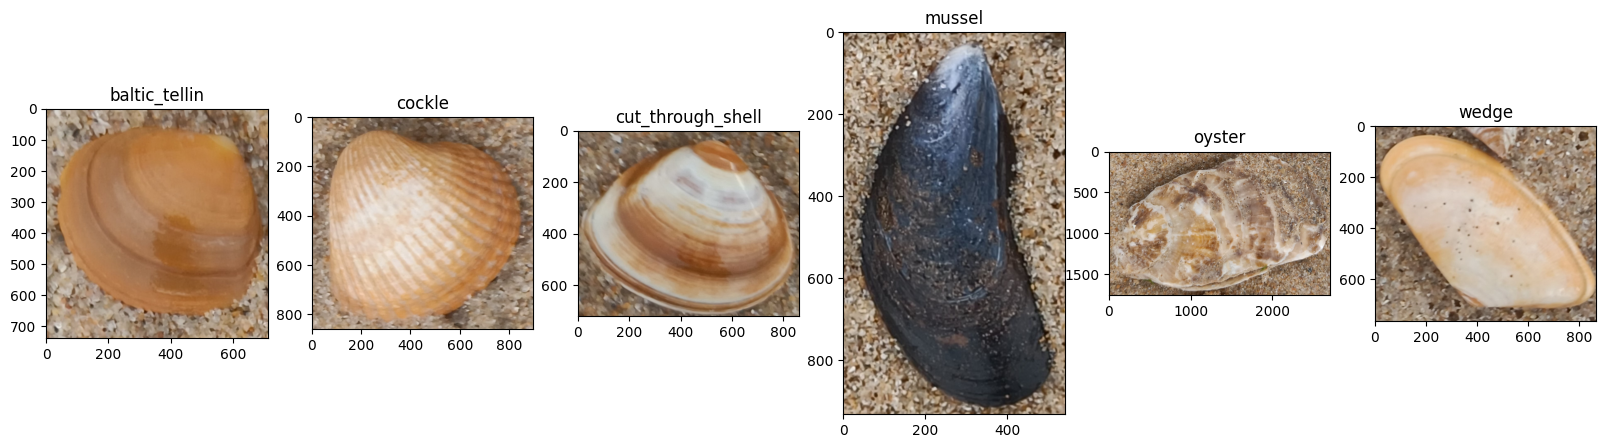

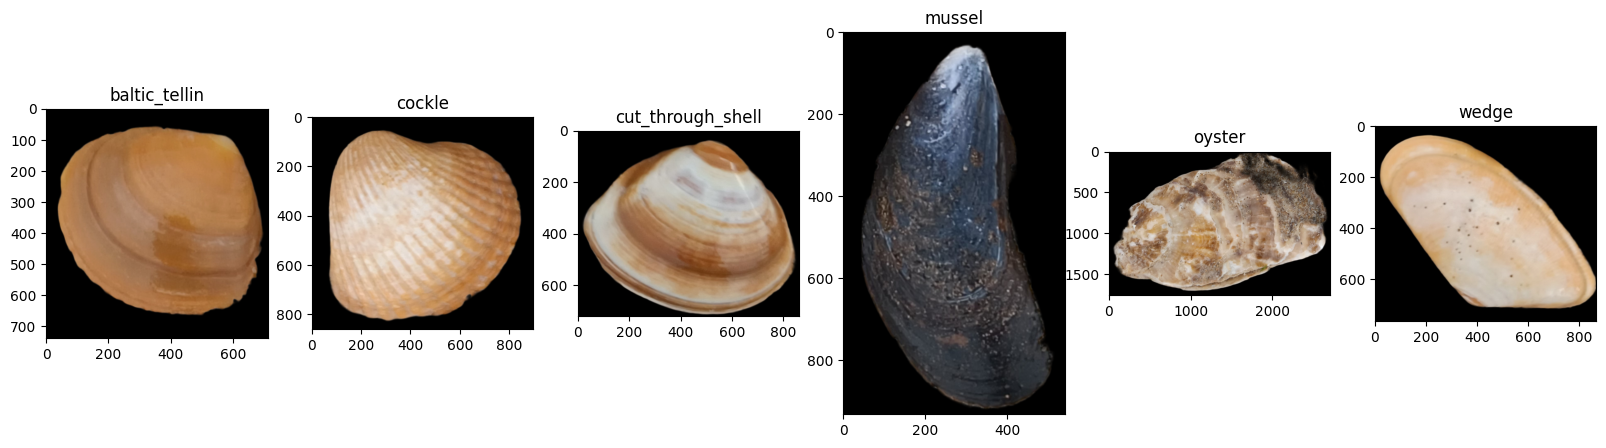

In [12]:
support_images_cutouts = orig_imgs.copy()

if remove_bg and (mode == USE_PICKED_IMAGE or mode == USE_RANDOM_IMAGE):
    # loop over all support images and remove background
    for class_name, img in support_images_cutouts.items():
        print(f"removing background from {class_name}")
        img_copy = img.copy()
        img_copy = remove(img_copy, bgcolor=(0, 0, 0, 0)).convert("RGB")
        support_images_cutouts[class_name] = img_copy
        
if mode == USE_PICKED_IMAGE or mode == USE_RANDOM_IMAGE:
    # show original images
    plt.figure(figsize=(20, 20))
    for i, (class_name, img) in enumerate(orig_imgs.items()):
        plt.subplot(1, len(orig_imgs), i + 1)
        plt.title(class_name)
        plt.imshow(img)
        print(img)
    if remove_bg:
        # show cutout images
        plt.figure(figsize=(20, 20))
        for i, (class_name, img) in enumerate(support_images_cutouts.items()):
            plt.subplot(1, len(support_images_cutouts), i + 1)
            plt.title(class_name)
            plt.imshow(img)
            print(img)
    
print(support_images_cutouts)
print(orig_imgs)

In [8]:
selected_img = 40
vals = list(orig_imgs.values())
print(vals)

test_image_annotated = query_images[selected_img]

test_image = test_image_annotated.image

test_image_filename = test_image_annotated.filename

print(test_image_filename)

# path = "../../../Data/shells/IMG20230217104337.jpg"

# test_image = Image.open(path)

print(test_image)

inputs = processor(query_images=vals, images=test_image, return_tensors="pt").to(device)
for key, val in inputs.items():
    print(f"{key}: {val.shape}")
    
outputs = model.image_guided_detection(**inputs)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()
outputs.pred_boxes = outputs.target_pred_boxes.cpu()
target_sizes = torch.Tensor([test_image.size[::-1]] * len(vals))

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=712x737 at 0x1F124B50070>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=899x862 at 0x1F124B50130>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=861x720 at 0x1F124BDA0A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=540x932 at 0x1F124BDA190>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2714x1755 at 0x1F124BDA1F0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=866x762 at 0x1F124BDA2B0>]
IMG20230217103213.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=8192x6144 at 0x1F124A17B20>
query_pixel_values: torch.Size([6, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])


In [9]:
score_threshold = 0.04
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold = score_threshold)
boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]

for i in range(1, len(support_images_cutouts.keys())):
    im_boxes, im_scores, im_labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
    boxes = torch.cat((boxes, im_boxes), dim=0)
    scores = torch.cat((scores, im_scores), dim=0)
    # add offset i to labels
    im_labels = im_labels + i
    labels = torch.cat((labels, im_labels), dim=0)
    

# non-maximum suppression with torchvision
if True:
    keep = torchvision.ops.nms(boxes, scores, iou_threshold=0.8)
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    if score >= score_threshold:
        print(f"Detected {list(support_images_cutouts.keys())[label]} with confidence {round(score.item(), 3)} at location {box}")
        
# draw bounding boxes on image
image = test_image.copy()
draw = ImageDraw.Draw(image)
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    if score >= score_threshold:
        draw.rectangle(box, outline="red", width=10)
        #add label and score
        draw.text((box[0]+10, box[1]+10), f"{list(support_images_cutouts.keys())[label]} {round(score.item(), 3)}", fill="red", font=ImageFont.truetype("arial", 120))

image.save("out_owlvit.jpg")

Detected baltic_tellin with confidence 0.95 at location [-1.29, 66.57, 8169.43, 6168.43]
Detected mussel with confidence 0.432 at location [-116.81, 219.66, 7991.38, 2744.46]
Detected oyster with confidence 0.395 at location [-26.01, 488.16, 7998.24, 4957.26]
Detected oyster with confidence 0.358 at location [-7.67, 31.35, 8152.39, 1795.23]
Detected oyster with confidence 0.326 at location [-68.6, 3.57, 8019.13, 3439.65]
Detected cut_through_shell with confidence 0.295 at location [-70.56, 322.29, 7984.65, 3980.77]
Detected cut_through_shell with confidence 0.268 at location [20.02, 170.66, 5905.28, 6264.04]
Detected mussel with confidence 0.233 at location [363.29, 989.81, 6022.93, 3335.89]
Detected wedge with confidence 0.231 at location [4742.4, 169.84, 7728.3, 1620.96]
Detected baltic_tellin with confidence 0.23 at location [4416.85, 886.0, 8247.64, 6206.96]
Detected oyster with confidence 0.229 at location [2840.55, 99.41, 8241.03, 6169.23]
Detected oyster with confidence 0.22 at 